# Linear trend filtering with periodic components

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scope import ScopeSolver

In this example, we consider a more complicated application generalizing the usual 1D trend filtering. Here, we suppose that the underlying true trend is piece-wise linear (rather than piece-wise constant) and some periodic components exist.

We generate such a time series $\mathbf{y}\in\mathbb{R}^p$ where $p=1000$ as follows:

- First, generate trend slopes $v_t$ from a Markov process such that $v_1=1$ and $v_{t+1}=v_t$ with probability 0.99 and from $U[-0.5, 0.5]$ with probability 0.01.  

- Then, generate true trend $x_t$ as $x_{t+1}=x_t+v_t, t=1,\cdots, p-1$ with $x_1=1$.  

- The periodic components are constructed as $s_t=a\times\sin(wt)+b\times\cos(wt)$ with $a=10, b=20, w=\pi/64$.

- Finally, the time series is generated by adding noise to the trend such that $y_t=x_t+s_t+z_t$ where $z_t$ are i.i.d. $\mathcal{N}(0, 10^2)$ noise.

In [4]:
np.random.seed(123)
p = 1000
sigma = 10
z = np.random.randn(p) * sigma
b = 0.5
v = np.ones(p)
prob = 0.99
rands = np.random.rand(p)
for i in range(1, p):
    rand = rands[i]
    if rand <= prob:
        v[i] = v[i-1]
    elif rand <= prob + (1-prob) / 2:
        v[i] = np.random.uniform(0, b)
    else:
        v[i] = - np.random.uniform(0, b)
x = np.ones(p)
for i in range(1, p):
    x[i] = x[i-1] + v[i-1]

w = np.pi / 64
periods = np.cumsum(np.ones((len(x), 2)), axis=0)
periods[:, 0] = np.sin(w * periods[:, 0])
periods[:, 1] = np.cos(w * periods[:, 1])
beta_period = np.array([10, 20])
s = periods @ beta_period
y = x + s + z

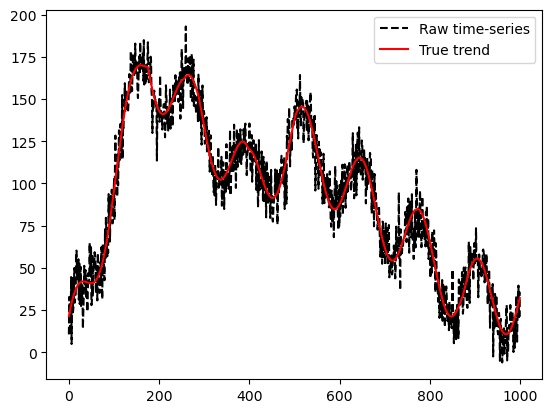

In [5]:
plt.plot(y,'k--' , label='Raw time-series')
plt.plot(x + s, 'r-', label='True trend')
plt.legend()
plt.show()

Given the time series $\bm{y}\in\mathbb{R}^p$, we want to recover the underlying piecewisly linear trend $\mathbf{x}$ and the periodic component $\mathbf{s}$. Here, we assume that $w$ is known but $a$ and $b$ are unknown. Similarly to the 1D trend filtering, we consider a reparametrization strategy which directly set the second order jump $\mathbf{\theta}$ as the sparse parameter.

Specifically, we can solve the following sparsity constrained optimization with ``scope``
$$
\min_{\bm{\theta}\in\mathbb{R}^p, a, b} \quad\frac{1}{2}\|\mathbf{y}-\mathbf{s}-\mathbf{A \theta}\|_2^2 \text{ s.t. } \|\mathbf{\theta}\|_0\leq s.
$$
where $s_t=a\sin(wt)+b\cos(wt)$ and $\bm{A}$ is the lower triangular matrix
$$
\bm{A}=\left[\begin{array}{cccccc}
1 & & & & & \\
1 & 1 & & & & \\
1 & 2 & 1 & & & \\
1 & 3 & 2 & \ddots & & \\
\vdots & \vdots & \vdots & \ddots & 1 & \\
1 & p-1 & p-2 & \cdots & 2 & 1
\end{array}\right] \in \mathbf{R}^{p \times p} .
$$
Then, we output $\bm{A\theta}$ as the underlying linear trend and $\mathbf{s}$ as the periodic component of $\bm{y}$.

We first construct the transformed matrix as follows.

In [3]:
A = np.zeros((p, p))
for i in range(p):
    if i == 0:
        A[:, i] = np.ones(p)
    else:
        A[:i, i] = np.zeros(i)
        A[i:, i] = np.arange(1, p-i+1)

The main function ``ptf`` cna be considered as a sparse linear regression with the design matrix being the concatenation of the base periodic components $\sin, \cos$ and $\mathbf{A}$ (see the function ``jnp.hstack`` below). 

In [109]:
def ptf(y, sparsity):
    def custom_objective(params):
        X_tmp = jnp.hstack([periods, A])
        loss = jnp.mean((y - X_tmp @ params) ** 2)
        return loss
    
    always_select = np.array([0, 1])
    solver = ScopeSolver(p+2, sparsity=sparsity, always_select=always_select)
    params = solver.solve(custom_objective)
    return params

We set the sparsity parameter as $18$ and visualize the estimated trend in the following figure.

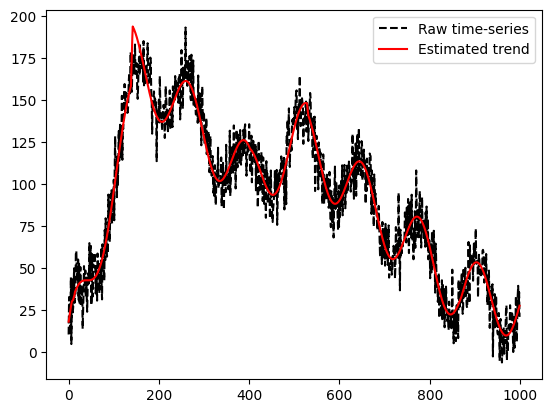

In [110]:
sparsity = 18
params = ptf(y, sparsity=sparsity)
comp1, comp2 = periods @ params[:2], A @ params[2:]

plt.plot(y, 'k--', label='Raw time-series')
plt.plot(comp1 + comp2, 'r-', label='Estimated trend')
plt.legend()
plt.show()

Moreover, we compare the estimated linear trend and periodic component with their true counterparts in the following figure.

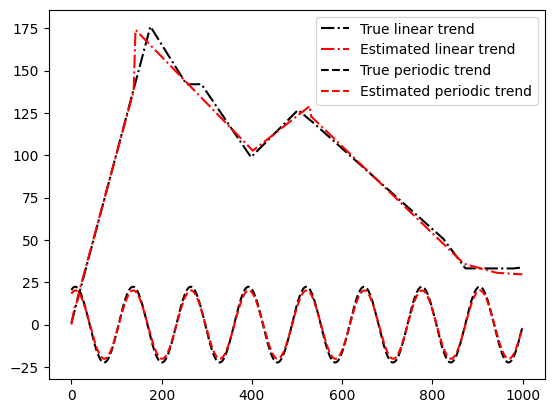

In [111]:
plt.plot(x, 'k-.', label='True linear trend')
plt.plot(comp2, 'r-.', label='Estimated linear trend')
plt.plot(s, 'k--', label='True periodic trend')
plt.plot(comp1, 'r--', label='Estimated periodic trend')
plt.legend()
plt.show()

# Reference

- [1] Kim S J, Koh K, Boyd S, et al. $\ell_1$ trend filtering[J]. SIAM review, 2009, 51(2): 339-360.